# Generating features

In [23]:
import ast
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import datetime
from functools import partial
from sklearn.inspection import permutation_importance
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

In [24]:
data_path = "./data/"

In [25]:
X_public = pd.read_csv(data_path + "train.csv", sep=";")
X_test = pd.read_csv(data_path + "test.csv", sep=";")
y_public = pd.read_csv(data_path + "train_labels.csv", sep=";", index_col="user_id")

In [26]:
def get_domain(row):
    # 8 - длина https://
    # потом берем domain
    return row["referer"][8:].split("/")[0]


def get_path(row):
    # 8 - длина https://
    # path - всегда или 0 хешей или 1
    splitted = row["referer"][8:].split("/")
    if len(splitted) == 1 or splitted[1] == "":
        return "none"
    return splitted[1]


X_public["domain"] = X_public.apply(get_domain, axis=1)
X_public["path"] = X_public.apply(get_path, axis=1)
X_test["domain"] = X_test.apply(get_domain, axis=1)
X_test["path"] = X_test.apply(get_path, axis=1)

referer_vectors = pd.read_csv(data_path + "referer_vectors.csv", sep=";")
geo_info = pd.read_csv(data_path + "geo_info.csv", sep=";")

X_public = pd.merge(X_public, referer_vectors, on="referer", how="left")
X_test = pd.merge(X_test, referer_vectors, on="referer", how="left")

X_public = pd.merge(X_public, geo_info, on="geo_id", how="left")
X_test = pd.merge(X_test, geo_info, on="geo_id", how="left")

In [5]:
def get_time_features(df):
    df["request_datetime"] = pd.to_datetime(df["request_ts"])
    df["hour"] = df["request_datetime"].dt.hour

    df["is_work_hours"] = ((df["hour"] >= 9) & (df["hour"] < 18)).astype(int)
    df["is_lunch_time"] = ((df["hour"] >= 12) & (df["hour"] < 14)).astype(int)

    return df


X_public = get_time_features(X_public)
X_test = get_time_features(X_test)

In [6]:
X_public["user_agent"] = X_public["user_agent"].fillna("{}")
X_test["user_agent"] = X_test["user_agent"].fillna("{}")


def extract_user_agent_features(df):
    user_agent_dicts = df["user_agent"].apply(ast.literal_eval)

    df["browser"] = user_agent_dicts.apply(lambda x: x.get("browser", "unknown"))
    df["browser_version"] = user_agent_dicts.apply(
        lambda x: x.get("browser_version", "unknown").split(".")[0]
    )
    df["browser+version"] = df["browser"] + df["browser_version"]
    df["os"] = user_agent_dicts.apply(lambda x: x.get("os", "unknown"))
    df["browser+os"] = df["browser"] + df["os"]
    df["os_version"] = user_agent_dicts.apply(lambda x: x.get("os_version", "unknown"))
    df["os+os_version"] = df["os"] + df["os_version"]

    df["browser+domain"] = df["browser"] + df["domain"]
    df["browser+os+domain"] = df["browser"] + df["os"] + df["domain"]
    df["country_id+domain"] = df["country_id"] + df["domain"]

    return df


X_public = extract_user_agent_features(X_public)
X_test = extract_user_agent_features(X_test)

In [7]:
def domain_referer_frequency(df, domain_col='domain', referer_col='referer'):
    domain_freq = df[domain_col].value_counts().reset_index()
    domain_freq.columns = [domain_col, 'domain_frequency']
    referer_freq = df[referer_col].value_counts().reset_index()
    referer_freq.columns = [referer_col, 'referer_frequency']
    df = df.merge(domain_freq, on=domain_col, how='left').merge(referer_freq, on=referer_col, how='left')
    return df

X_public = domain_referer_frequency(X_public)
X_test = domain_referer_frequency(X_test)

In [8]:
def path_frequency(df, path_col='path'):
    path_freq = df[path_col].value_counts().reset_index()
    path_freq.columns = [path_col, 'path_frequency']
    df = df.merge(path_freq, on=path_col, how='left')
    return df

X_public = path_frequency(X_public)
X_test = path_frequency(X_test)

In [9]:
X_public["count_user_id"] = X_public.groupby("user_id")["user_id"].transform("count")
X_test["count_user_id"] = X_test.groupby("user_id")["user_id"].transform("count")

for col in referer_vectors.columns[:-1]:
    X_public[f"mean_{col}_by_user_id"] = X_public.groupby("user_id")[col].transform(
        "mean"
    )
    X_test[f"mean_{col}_by_user_id"] = X_test.groupby("user_id")[col].transform("mean")

X_public["unique_domains_by_user_id"] = X_public.groupby("user_id")["domain"].transform(
    "nunique"
)
X_test["unique_domains_by_user_id"] = X_test.groupby("user_id")["domain"].transform(
    "nunique"
)

X_public["unique_path"] = X_public.groupby("user_id")["path"].transform("nunique")
X_test["unique_path"] = X_test.groupby("user_id")["path"].transform("nunique")

all_components = [
    "component0",
    "component1",
    "component2",
    "component3",
    "component4",
    "component5",
    "component6",
    "component7",
    "component8",
    "component9",
]

# X_public["median_component"] = X_public[all_components].median(axis=1)
# X_test["median_component"] = X_test[all_components].median(axis=1)
X_public["mean_component"] = X_public[all_components].mean(axis=1)
X_test["mean_component"] = X_test[all_components].mean(axis=1)

In [27]:
X_public = pd.merge(X_public, y_public, on="user_id")
y_public = X_public["target"]
X_public = X_public.drop(columns=["target"])

In [11]:
cat_features = X_public.columns[X_public.dtypes == object].to_numpy()
cat_features

array(['user_id', 'referer', 'user_agent', 'domain', 'path', 'country_id',
       'region_id', 'timezone_id', 'browser', 'browser_version',
       'browser+version', 'os', 'browser+os', 'os_version',
       'os+os_version', 'browser+domain', 'browser+os+domain',
       'country_id+domain'], dtype=object)

# Creating plots

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

X_public["target"] = y_public

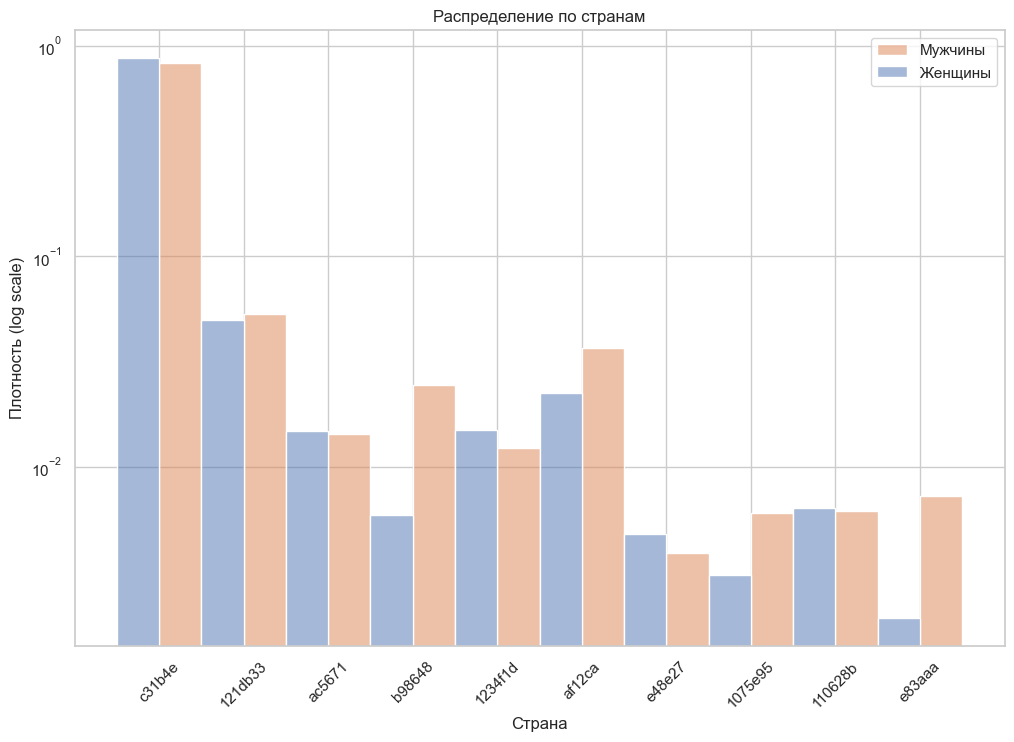

In [29]:
top_countries = X_public["country_id"].value_counts().head(10).index

plt.figure(figsize=(12, 8))
sns.histplot(data=X_public[X_public["country_id"].isin(top_countries)], x="country_id", hue="target", multiple="dodge", stat="density", common_norm=False, alpha=0.5)
plt.xlabel("Страна")
plt.ylabel("Плотность (log scale)")
plt.title("Распределение по странам")
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(labels=["Мужчины", "Женщины"])
plt.show()

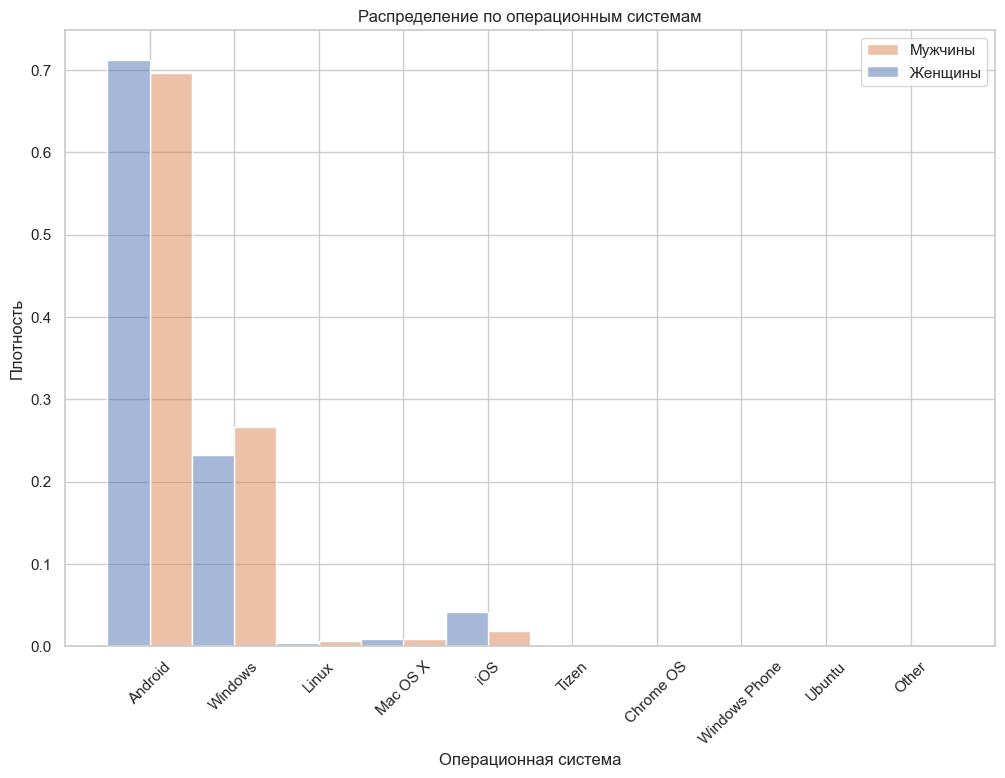

In [18]:
top_os = X_public["os"].value_counts().head(10).index

plt.figure(figsize=(12, 8))
sns.histplot(data=X_public[X_public["os"].isin(top_os)], x="os", hue="target", multiple="dodge", stat="density", common_norm=False, alpha=0.5)
plt.xlabel("Операционная система")
plt.ylabel("Плотность")
plt.title("Распределение по операционным системам")
plt.xticks(rotation=45)
plt.legend(labels=["Мужчины", "Женщины"])
plt.show()

In [22]:
top_countries = X_public["country_id"].value_counts().head(10).index

plt.figure(figsize=(12, 8))
sns.histplot(data=X_public[X_public["country_id"].isin(top_countries)], x="country_id", hue="target", multiple="dodge", stat="density", common_norm=False, alpha=0.5)
plt.xlabel("Страна")
plt.ylabel("Плотность (log scale)")
plt.title("Распределение по странам")
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(labels=["Мужчины", "Женщины"])
plt.show()

NameError: name 'plt' is not defined

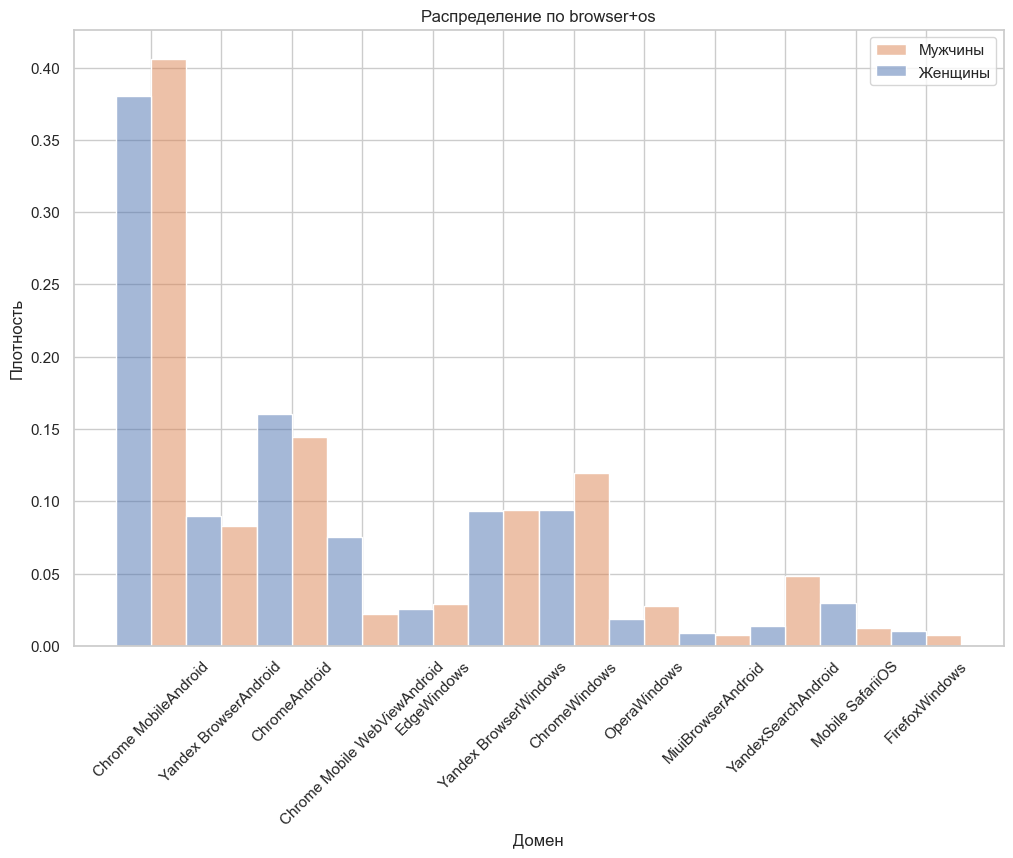

In [29]:
top_domains = X_public["browser+os"].value_counts().head(12).index

plt.figure(figsize=(12, 8))
sns.histplot(data=X_public[X_public["browser+os"].isin(top_domains)], x="browser+os", hue="target", multiple="dodge", stat="density", common_norm=False, alpha=0.5)
plt.xlabel("Домен")
plt.ylabel("Плотность")
plt.title("Распределение по browser+os")
plt.xticks(rotation=45)
plt.legend(labels=["Мужчины", "Женщины"])
plt.show()

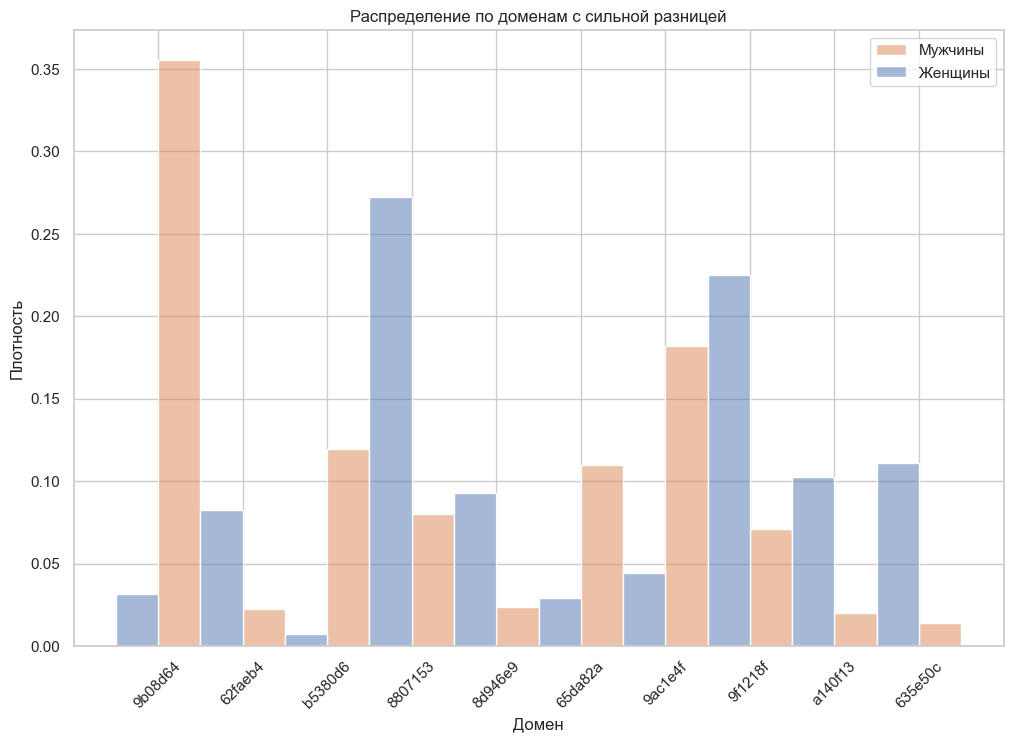

In [38]:
def get_strong_imbalance(df, column, threshold=0.6):
    counts = df.groupby([column, "target"]).size().unstack(fill_value=0)
    counts["total"] = counts.sum(axis=1)
    counts["female_ratio"] = counts[1] / counts["total"]
    counts["male_ratio"] = counts[0] / counts["total"]
    return counts[(counts["female_ratio"] >= threshold) | (counts["male_ratio"] >= threshold)]


domain_imbalance = get_strong_imbalance(X_public, "domain")
top_10_domain_imbalance = domain_imbalance.sort_values("total", ascending=False).head(10).index

plt.figure(figsize=(12, 8))
sns.histplot(data=X_public[X_public["domain"].isin(top_10_domain_imbalance)], x="domain", hue="target", multiple="dodge", stat="density", common_norm=False, alpha=0.5)
plt.xlabel("Домен")
plt.ylabel("Плотность")
plt.title("Распределение по доменам с сильной разницей")
plt.xticks(rotation=45)
plt.legend(labels=["Мужчины", "Женщины"])
plt.show()

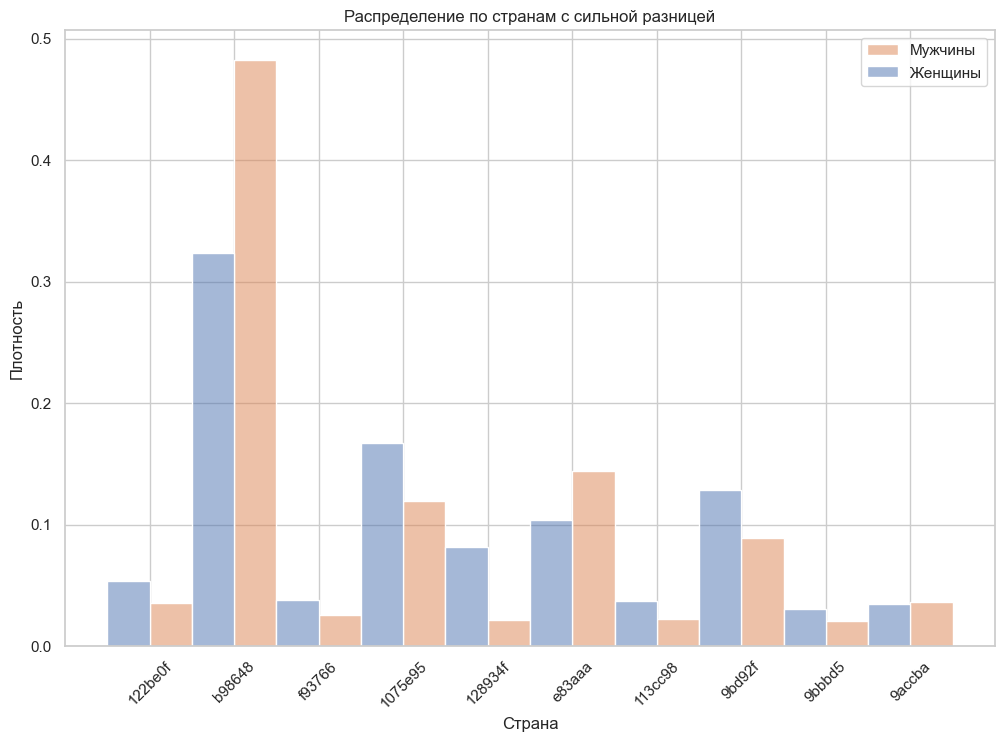

In [55]:
def get_strong_imbalance(df, column, threshold=0.6):
    counts = df.groupby([column, "target"]).size().unstack(fill_value=0)
    counts["total"] = counts.sum(axis=1)
    counts["female_ratio"] = counts[1] / counts["total"]
    counts["male_ratio"] = counts[0] / counts["total"]
    return counts[(counts["female_ratio"] >= threshold) | (counts["male_ratio"] >= threshold)]


domain_imbalance = get_strong_imbalance(X_public, "country_id")
top_10_domain_imbalance = domain_imbalance.sort_values("total", ascending=False).head(10).index

plt.figure(figsize=(12, 8))
sns.histplot(data=X_public[X_public["country_id"].isin(top_10_domain_imbalance)], x="country_id", hue="target", multiple="dodge", stat="density", common_norm=False, alpha=0.5)
plt.xlabel("Страна")
plt.ylabel("Плотность")
# plt.yscale('log')
plt.title("Распределение по странам с сильной разницей")
plt.xticks(rotation=45)
plt.legend(labels=["Мужчины", "Женщины"])
plt.show()

In [60]:
X_public['count_user_id'].value_counts()

1    415304
2    141736
3     34488
4      7980
5      1355
6       276
8        72
7        70
9         9
Name: count_user_id, dtype: int64

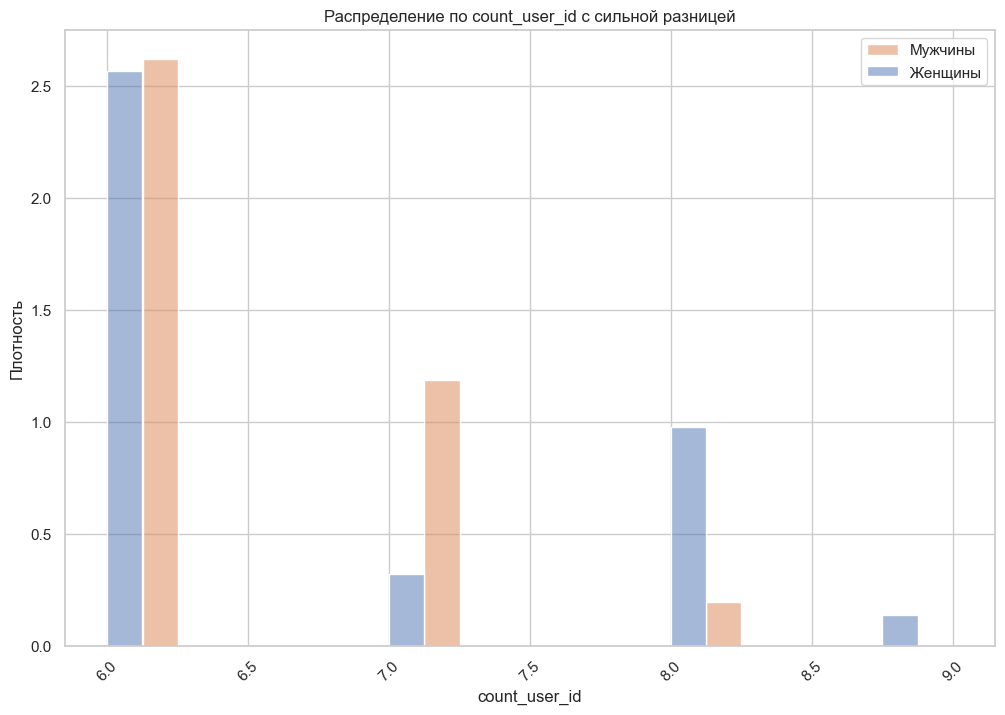

In [59]:
def get_strong_imbalance(df, column, threshold=0.6):
    counts = df.groupby([column, "target"]).size().unstack(fill_value=0)
    counts["total"] = counts.sum(axis=1)
    counts["female_ratio"] = counts[1] / counts["total"]
    counts["male_ratio"] = counts[0] / counts["total"]
    return counts[(counts["female_ratio"] >= threshold) | (counts["male_ratio"] >= threshold)]


domain_imbalance = get_strong_imbalance(X_public, "count_user_id")
top_10_domain_imbalance = domain_imbalance.sort_values("count_user_id", ascending=False).head(10).index

plt.figure(figsize=(12, 8))
sns.histplot(data=X_public[X_public["count_user_id"].isin(top_10_domain_imbalance)], x="count_user_id", hue="target", multiple="dodge", stat="density", common_norm=False, alpha=0.5)
plt.xlabel("count_user_id")
plt.ylabel("Плотность")
# plt.yscale('log')
plt.title("Распределение по count_user_id с сильной разницей")
plt.xticks(rotation=45)
plt.legend(labels=["Мужчины", "Женщины"])
plt.show()

In [39]:
X_public.dtypes

request_ts                             int64
user_id                               object
referer                               object
geo_id                                 int64
user_agent                            object
domain                                object
path                                  object
component0                             int64
component1                             int64
component2                             int64
component3                             int64
component4                             int64
component5                             int64
component6                             int64
component7                             int64
component8                             int64
component9                             int64
country_id                            object
region_id                             object
timezone_id                           object
request_datetime              datetime64[ns]
hour                                   int64
is_work_ho

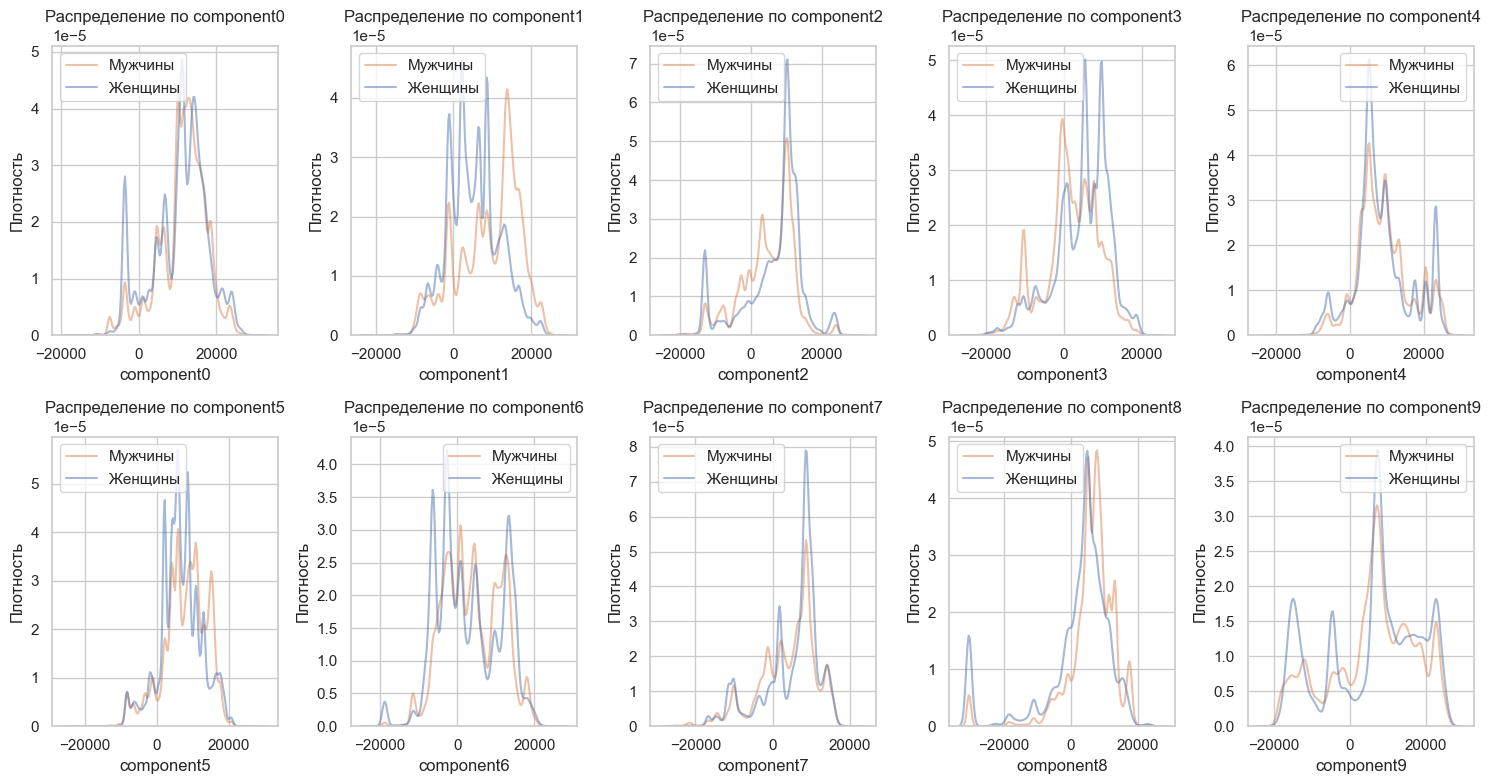

In [49]:
float_features = [
    "component0",
    "component1",
    "component2",
    "component3",
    "component4",
    "component5",
    "component6",
    "component7",
    "component8",
    "component9",
    # "domain_frequency",
    # "referer_frequency",
]

X_public["target"] = y_public


def plot_kde_features(features, data):
    n_features = len(features)
    n_cols = 5
    n_rows = (n_features + n_cols - 1) // n_cols
    plt.figure(figsize=(15, 4 * n_rows))

    for i, feature in enumerate(features):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.kdeplot(data=data, x=feature, hue="target", common_norm=True, alpha=0.5)
        plt.xlabel(feature)
        plt.ylabel("Плотность")
        plt.title(f"Распределение по {feature}")
        plt.legend(labels=["Мужчины", "Женщины"])
    plt.tight_layout()
    plt.show()


plot_kde_features(float_features, X_public)